https://www.kaggle.com/code/harlequeen/semantic-segmentation-of-plants-with-segnet/notebook

# Libraries needed for this notebook

In [1]:
import cv2
import imageio
from PIL import Image
import numpy as np
from keras import backend as K
from keras.layers import Layer
from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
from keras.models import Model
import argparse
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import BatchNormalization


2023-03-23 15:02:06.462165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 15:02:06.768774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jy/PycharmProjects/Perception-Resources/venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-23 15:02:06.768810: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 15:02:08.114727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic l

# Customized Maxpooling/Unpooling Layers

Reference: https://github.com/ykamikawa/tf-keras-SegNet

In [2]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')

            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3])

            ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                  K.flatten(updates),
                                  [K.prod(output_shape)])

            input_shape = updates.shape
            out_shape = [-1,
                         input_shape[1] * self.size[0],
                         input_shape[2] * self.size[1],
                         input_shape[3]]
        return K.reshape(ret, out_shape)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

# Segnet model with some customized layers

reference : https://github.com/ykamikawa/tf-keras-SegNet

In [3]:
    
def segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)


    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_6)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    
    
    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_8)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
   

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_11)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    

    unpool_2 = MaxUnpooling2D(pool_size)([conv_14, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_17)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(128, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
   
    unpool_4 = MaxUnpooling2D(pool_size)([conv_21, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
        (input_shape[0] * input_shape[1], n_labels),
        input_shape=(input_shape[0], input_shape[1], n_labels),
    )(conv_26)

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model


model = segnet((224,224,3), n_labels=6 ,kernel=3, pool_size=(2,2), output_mode="softmax")

print(model.summary())

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

2023-03-23 15:02:11.061231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 15:02:11.061761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jy/PycharmProjects/Perception-Resources/venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-23 15:02:11.061893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jy/PycharmProjects/Perception-Resources/venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-23 15:02:11.061997: W tensorflow/compiler/xla/s

Build enceder done..
Build decoder done..
Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                  

# Data generator

In [4]:
def exr_to_jpg(path):
    im = imageio.imread(path)
    im_gamma_correct = np.clip(np.power(im, 0.45), 0, 1)
    im_fixed = Image.fromarray(np.uint8(im_gamma_correct*255))
    return im_fixed

def category_label(labels, dims, n_labels):
    x = np.zeros([dims[0], dims[1], n_labels])
    for i in range(dims[0]):
        for j in range(dims[1]):
            f=int(labels[i,j])
            x[i, j, f] = 1
    x = x.reshape(dims[0] * dims[1], n_labels)
    return x
def colorize(img):
    w=img.shape[0]
    h=img.shape[1]
    z=img.shape[2]
    l=np.zeros((w,h,3))

    for i in range(w):
        for j in range(h):
            if img[i,j,0]==1:
                l[i,j,0]=0
                l[i,j,1]=0
                l[i,j,2]=0
            elif img[i,j,1]==1:
                l[i,j,0]=255
                l[i,j,1]=0
                l[i,j,2]=0
            elif img[i,j,2]==1:
                l[i,j,0]=0
                l[i,j,1]=255
                l[i,j,2]=0
            elif img[i,j,3]==1:
                l[i,j,0]=0
                l[i,j,1]=0
                l[i,j,2]=255
            elif img[i,j,4]==1:
                l[i,j,0]=238
                l[i,j,1]=197
                l[i,j,2]=145
    return l

def class_pixels(img):
    w=img.shape[0]
    h=img.shape[1]
    z=img.shape[2]
    l=np.zeros((w,h,z))
    for i in range(w):
        for j in range(h):
            for f in range(z-1):
                if img[i,j,f]==np.max([img[i,j,0],img[i,j,1],img[i,j,2],img[i,j,3],img[i,j,4]]):
                    l[i,j,f]=1
    return l

def data_gen_small(img_dir,mask_dir,depth_dir,liste, batch_size, dims=(224,224), n_labels=5):
    while True:
        ix = np.random.choice(liste, batch_size)
        imgs = []
        labels = []
        for index in ix:
            print(index, ix)
            # images
            img_path = img_dir[index]
            original_img = exr_to_jpg(img_path)
            array_img = img_to_array(original_img)/255
            imgs.append(array_img)
            
            # masks
            mask_path = mask_dir[index]
            original_mask=cv2.imread(mask_path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
            array_mask = category_label(original_mask[:, :, 0], dims, n_labels)
            labels.append(array_mask)
            
        imgs = np.array(imgs)
        labels = np.array(labels)
        yield imgs, labels

# Data preprocessing and splitting

In [5]:
import os
rgb=[]
depth=[]
mask=[]
node=[]

for dirs,subdir,files in os.walk('./input/synthetic-rgbd-images-of-plants/'):
    for file_name in files:
        if file_name.endswith(".exr"):
            path_file=dirs+os.sep+file_name
            rgb_file='./input/synthetic-rgbd-images-of-plants/rgb_map/'+file_name
            depth_file='./input/synthetic-rgbd-images-of-plants/depth_map/profondeur_map/'+file_name
            mask_file='./input/synthetic-rgbd-images-of-plants/semantic_map/segmentation2_map/'+file_name
            node_file='./input/synthetic-rgbd-images-of-plants/nodes_map/internoeuds_map/'+file_name
            rgb.append(rgb_file)
            depth.append(depth_file)
            mask.append(mask_file)
            node.append(node_file)
            
liste=np.arange(1,10000)
np.random.shuffle(liste)

train_list=liste[0:8000]
val_list=liste[8000:9000]
test_list=liste[9000:9999]


train_gen = data_gen_small(rgb
,mask,depth,liste=train_list,batch_size=16,dims=(224,224),n_labels=5)
val_gen=data_gen_small(rgb
,mask,depth,liste=val_list,batch_size=16,dims=(224,224),n_labels=5)
test_gen = data_gen_small(rgb
,mask,depth,liste=test_list,batch_size=1,dims=(224,224),n_labels=5)

In [6]:
print(len(rgb))
print(len(depth))

50000
50000


# Metrics

Because the dataset contains imbalanced number of classes in each image, it's better to use a proper metric for that, which is Dice Coefficient.

In [7]:
def dice_coef(y_true, y_pred): 
    
    epsilon=1e-6
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return K.mean((numerator + epsilon) / (denominator + epsilon))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [8]:
model.compile(loss=dice_coef_loss, optimizer='adam', metrics=["accuracy",dice_coef])

# Training

It took me while to train the model ( 24h on four external GPUs ). So will just write the code for training and load the trained model after.

In [9]:
history=model.fit_generator(
        train_gen,
        steps_per_epoch=500,
        epochs=50,
        validation_data=val_gen,
        validation_steps=62
    )

4693 [4693 2242 3344 5045 2509 4826 8898 3020 8966 5985 2135 8588 7369 7290
 6580 9941]


/tmp/ipykernel_79306/253716820.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(
/tmp/ipykernel_79306/2741943633.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path)
[ WARN:0@4.140] global grfmt_exr.cpp:102 initOpenEXR imgcodecs: OpenEXR codec is disabled. You can enable it via 'OPENCV_IO_ENABLE_OPENEXR' option. Refer for details and cautions here: https://github.com/opencv/opencv/issues/21326


error: OpenCV(4.7.0) /io/opencv/modules/imgcodecs/src/grfmt_exr.cpp:103: error: (-213:The function/feature is not implemented) imgcodecs: OpenEXR codec is disabled. You can enable it via 'OPENCV_IO_ENABLE_OPENEXR' option. Refer for details and cautions here: https://github.com/opencv/opencv/issues/21326 in function 'initOpenEXR'


# Post-training

Here is the model trained on the same training set but externally in a server of 4 GPUs. Couldn't finish the training here because of the GPU quota and the successive shutdowns of the session.

In [9]:
import h5py
weights_filepath = './input/pre-model-2/only_rgb_dice.hdf5'
print("__")
with h5py.File(weights_filepath, 'r') as f:
    print(f.keys())
    print("===================")
    for k in f.keys():
        for l in f[k].keys():
            for m in f[k][l].keys():
                print(k+ " : " + m + " : " + str(f[k][l][m].shape))

__
<KeysViewHDF5 ['activation_1', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'batch_normalization_1', 'batch_normalization_10', 'batch_normalization_11', 'batch_normalization_12', 'batch_normalization_13', 'batch_normalization_14', 'batch_normalization_15', 'batch_normalization_16', 'batch_normalization_17', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_5', 'batch_normalization_6', 'batch_normalization_7', 'batch_normalization_8', 'batch_normalization_9', 'conv2d_1', 'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'conv2d_16', 'conv2d_17', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'input_1', 'max_pooling_with_argmax2d_1', 'max_pooling_wi

In [10]:
model.load_weights('./input/pre-model-2/only_rgb_dice.hdf5')

# Training and validation curves

Once again I uploaded the history of my external training.

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# plotting of training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

# ***Inference on test data***

In [12]:
testbed_img = []
for dirs,subdir,files in os.walk('./input/testbed/'):
    for file_name in files:
        if file_name.endswith(".jpg"):
            testbed_file='./input/testbed/'+file_name
            testbed_img.append(testbed_file)
print(testbed_img)

['./input/testbed/IMG_1014.jpg', './input/testbed/IMG_1013.jpg', './input/testbed/IMG_0996.jpg', './input/testbed/IMG_0987.jpg', './input/testbed/IMG_0974.jpg', './input/testbed/IMG_0986.jpg', './input/testbed/IMG_0984.jpg', './input/testbed/IMG_0992.jpg', './input/testbed/IMG_0983.jpg', './input/testbed/IMG_1001.jpg', './input/testbed/IMG_0973.jpg', './input/testbed/IMG_1003.jpg', './input/testbed/IMG_0976.jpg', './input/testbed/IMG_1010.jpg', './input/testbed/IMG_1015.jpg', './input/testbed/IMG_0993.jpg', './input/testbed/IMG_1009.jpg', './input/testbed/IMG_1008.jpg', './input/testbed/IMG_0980.jpg', './input/testbed/IMG_0998.jpg', './input/testbed/IMG_0985.jpg', './input/testbed/IMG_0988.jpg', './input/testbed/IMG_1007.jpg', './input/testbed/IMG_1005.jpg', './input/testbed/IMG_0978.jpg', './input/testbed/IMG_0997.jpg', './input/testbed/IMG_0975.jpg', './input/testbed/IMG_0982.jpg', './input/testbed/IMG_0981.jpg', './input/testbed/IMG_0977.jpg', './input/testbed/IMG_1002.jpg', './inpu

In [13]:
def reshape_jpg(img):
    img = np.reshape(img, (1,224,224,3))
    return img

/tmp/ipykernel_7828/2741943633.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path)
/tmp/ipykernel_7828/3404475701.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_img = imageio.imread(img_path)


1/1 [==============================] - 1s 912ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


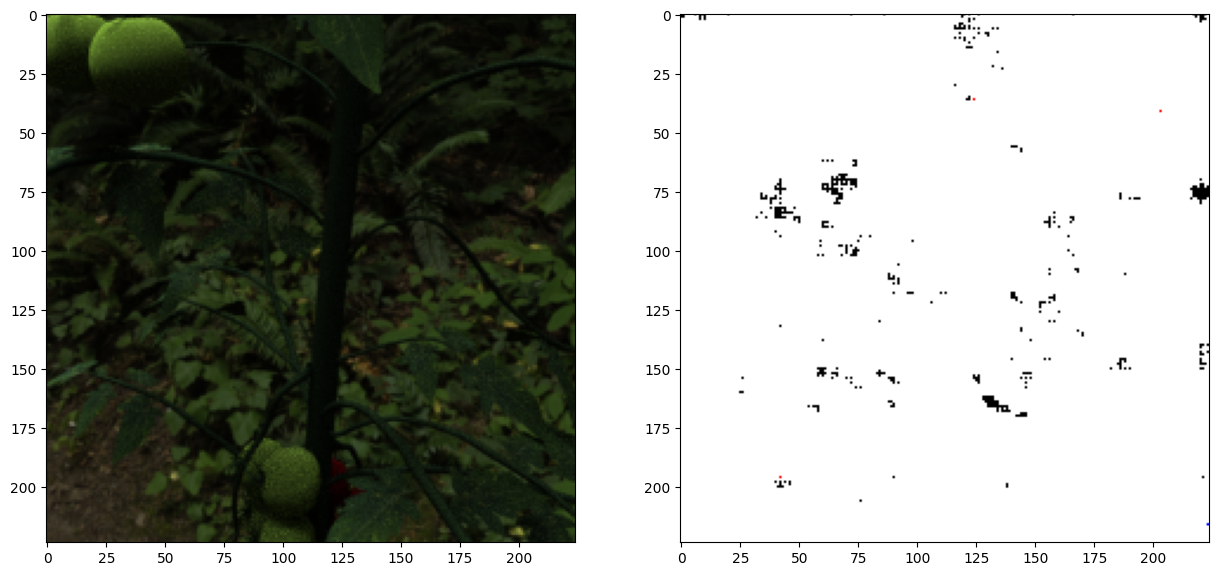

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 207ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


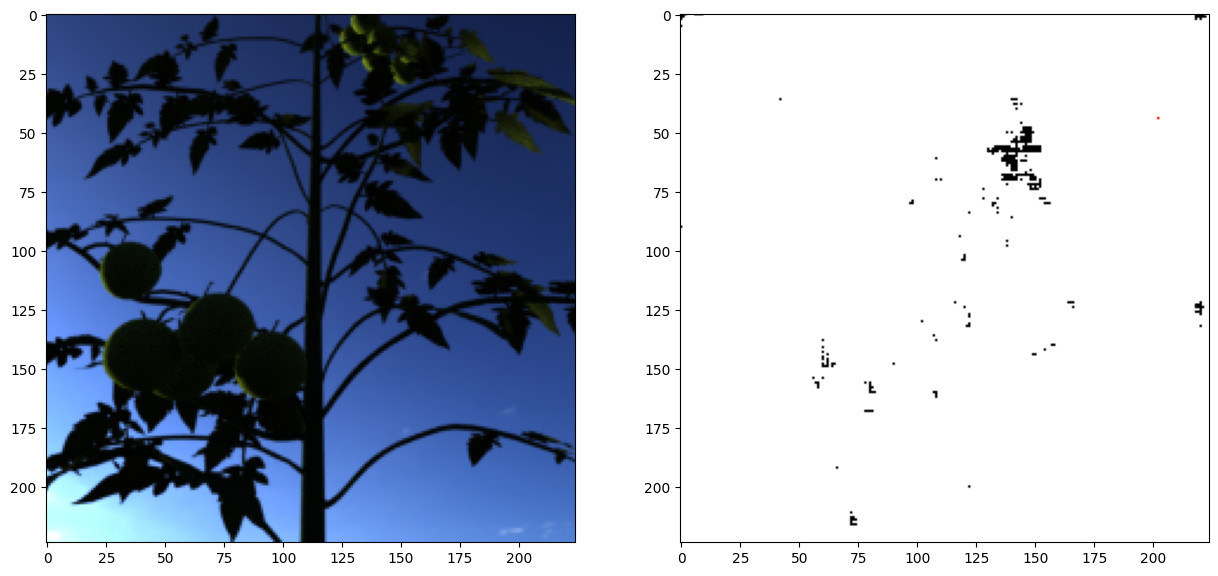

1/1 [==============================] - 0s 279ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


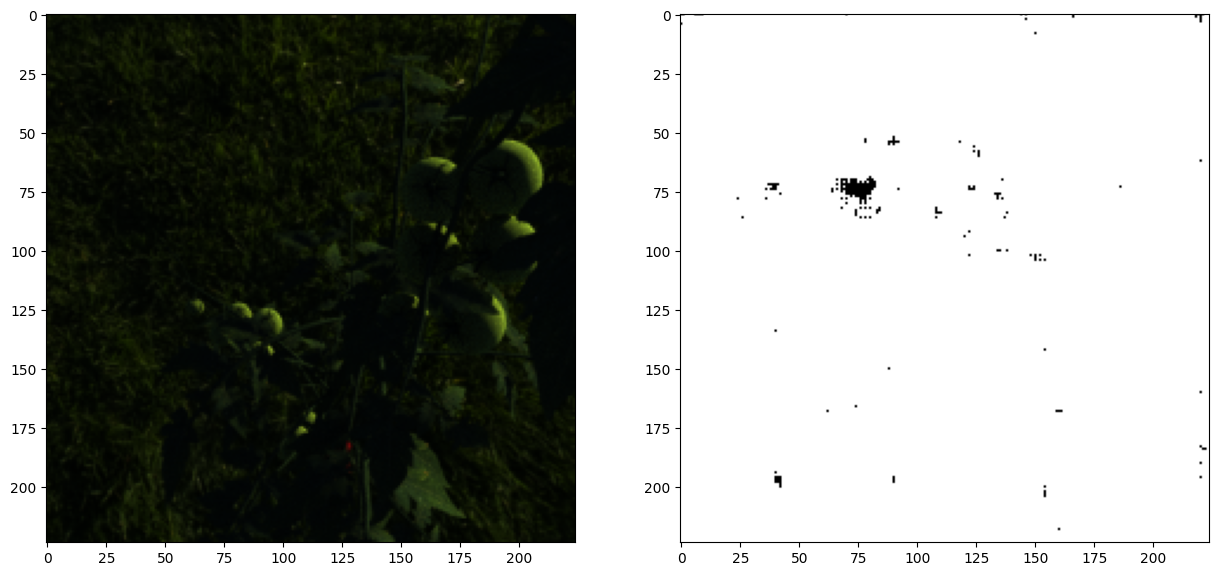

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 192ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


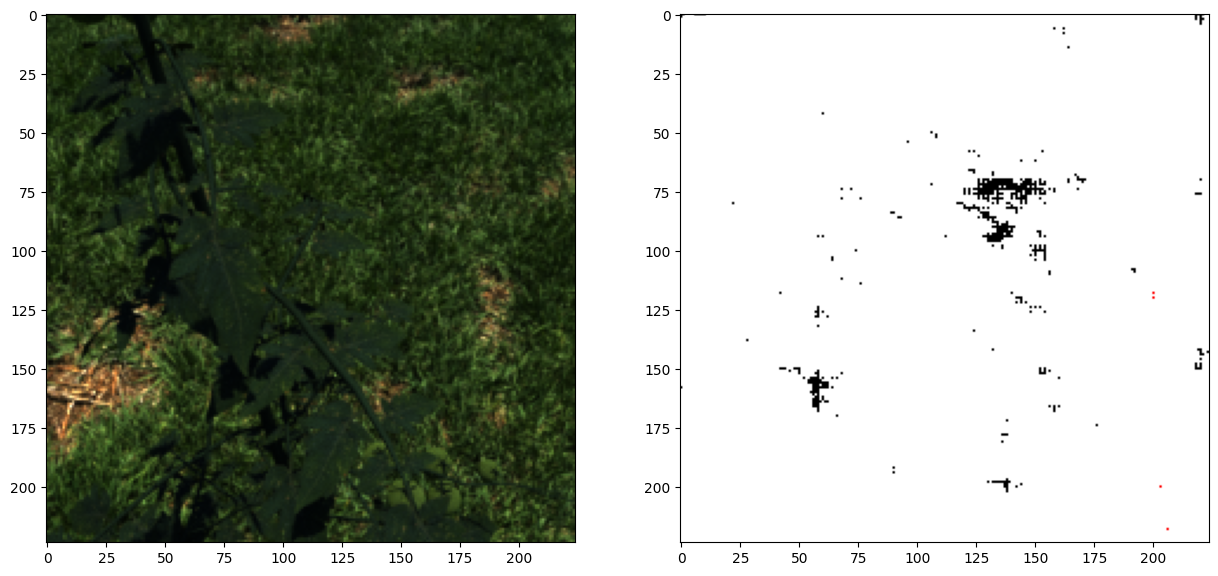

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 273ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


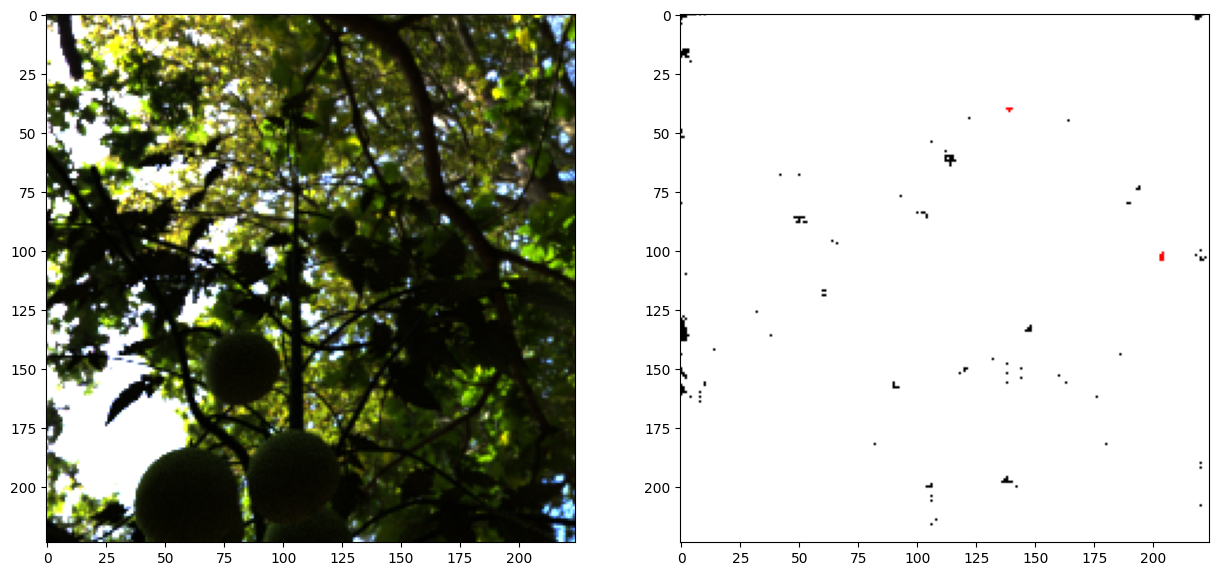

1/1 [==============================] - 0s 211ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


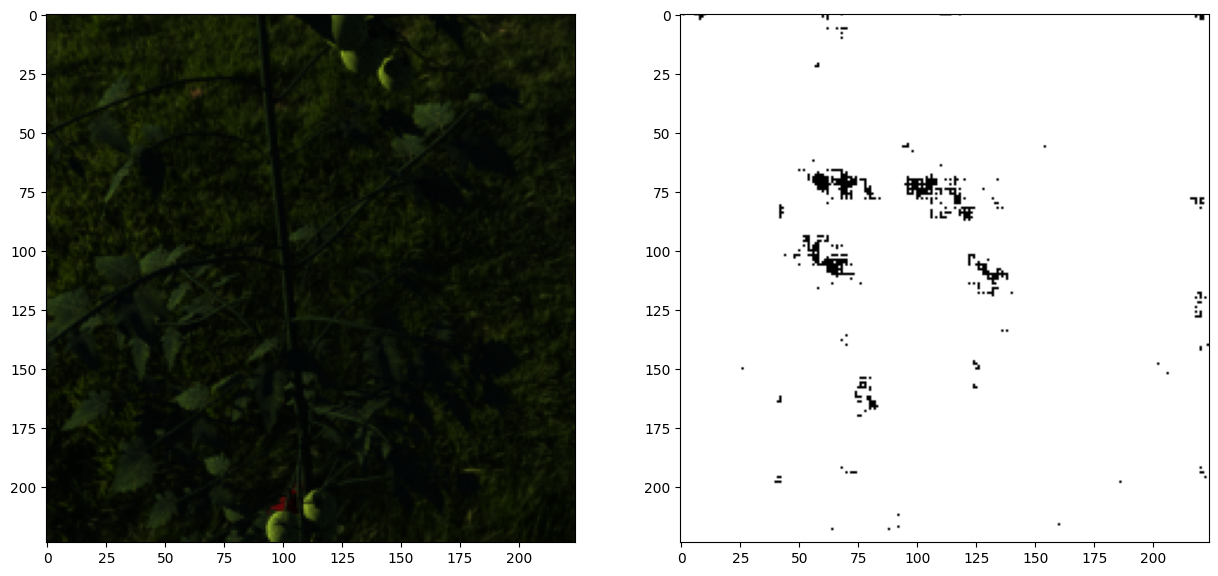

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 225ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


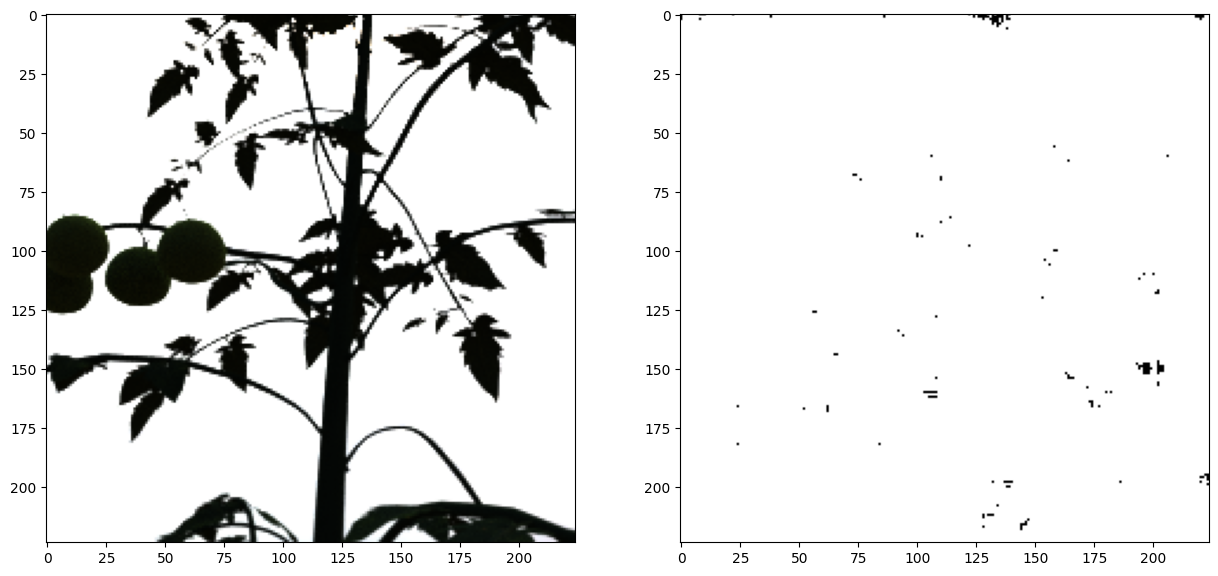

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 202ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


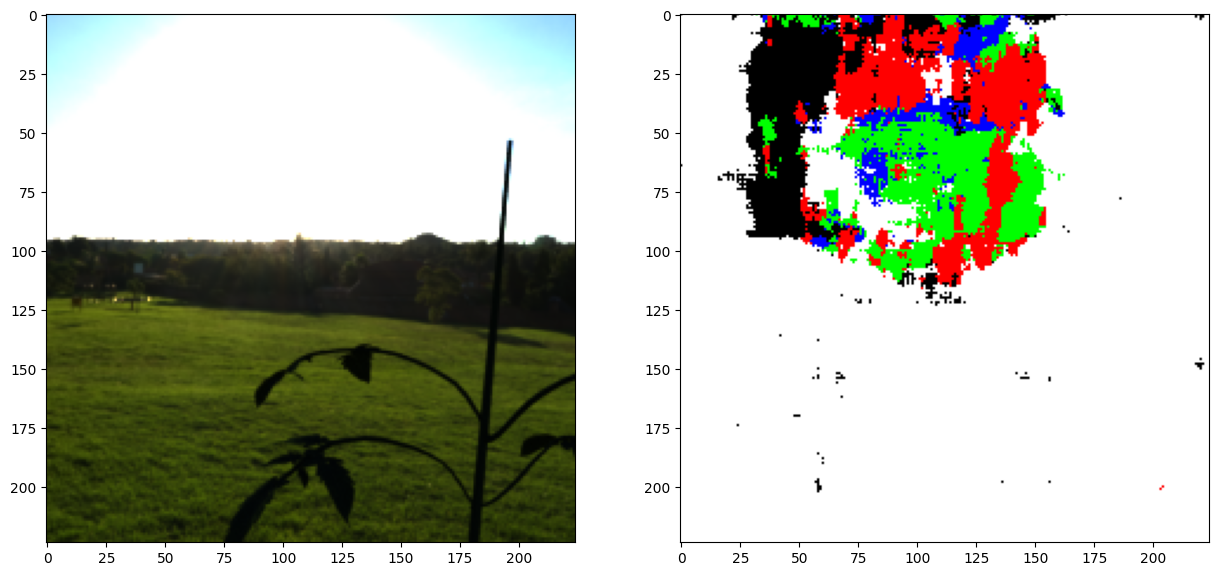

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 192ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


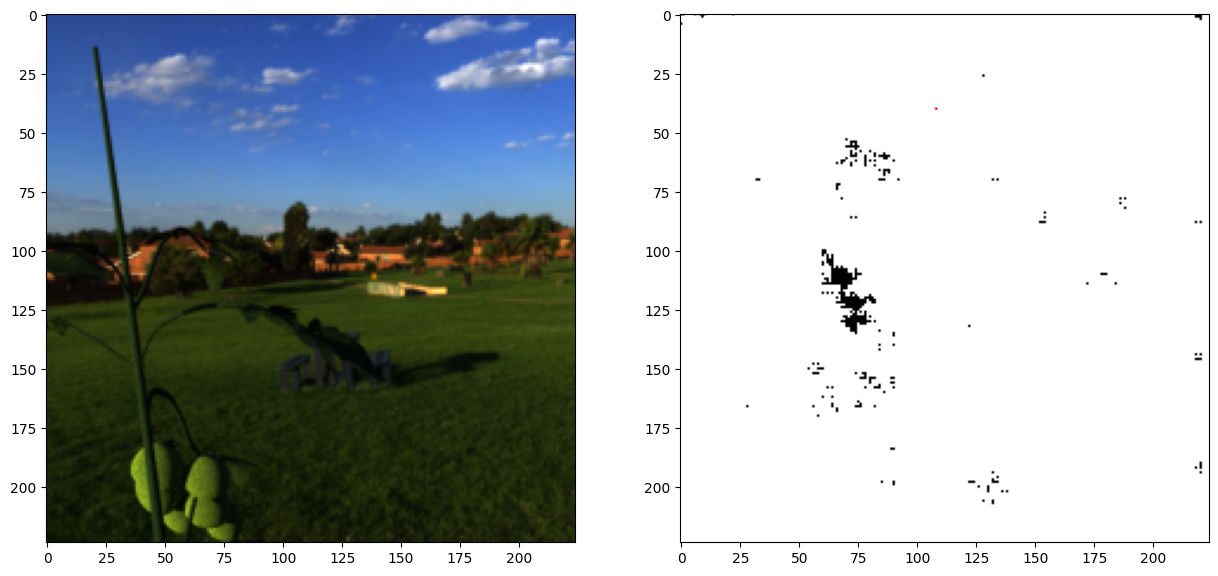

1/1 [==============================] - 0s 228ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


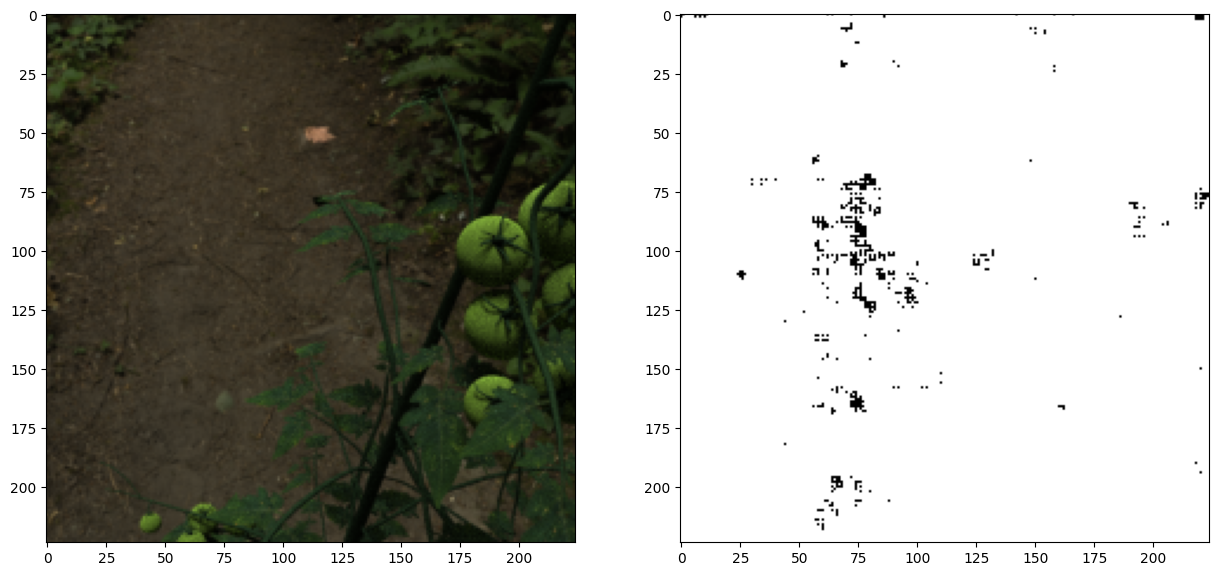

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 225ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


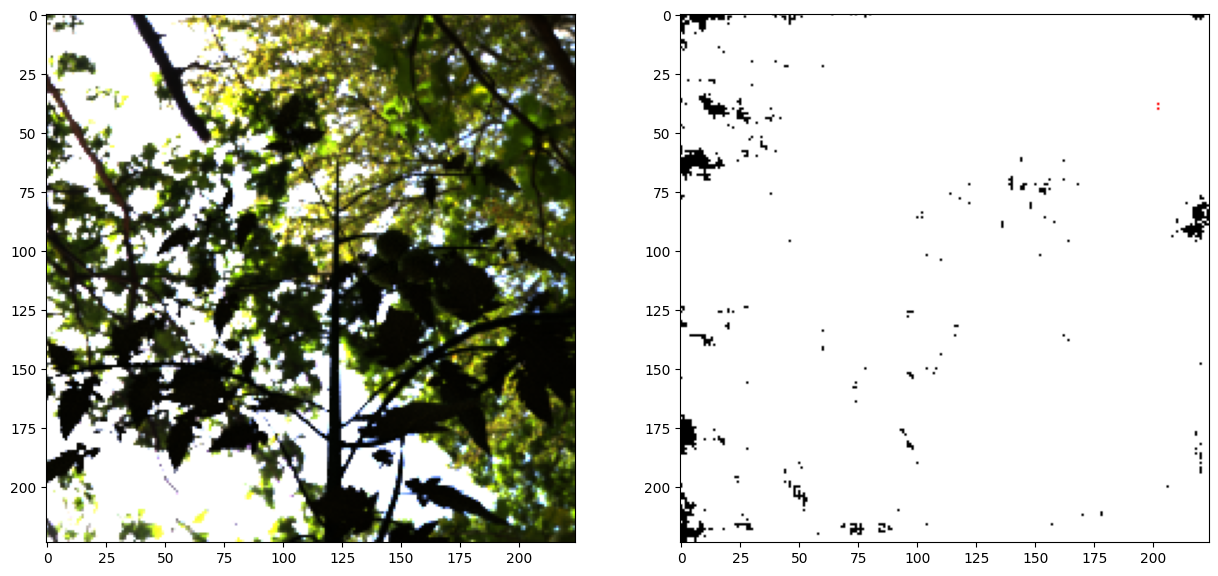

1/1 [==============================] - 0s 221ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


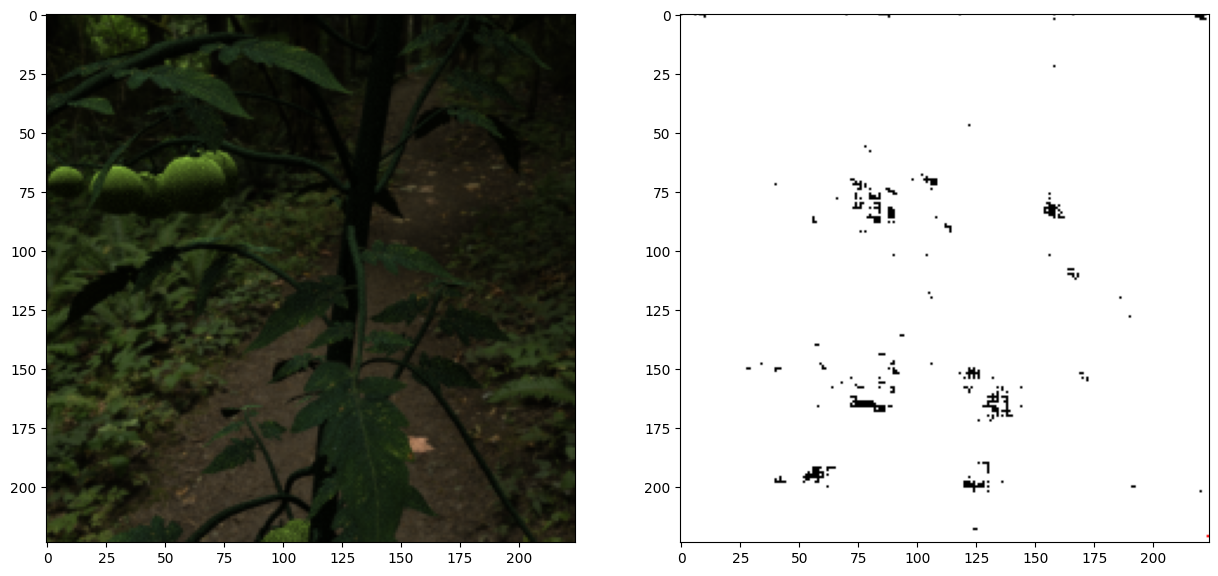

1/1 [==============================] - 0s 199ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


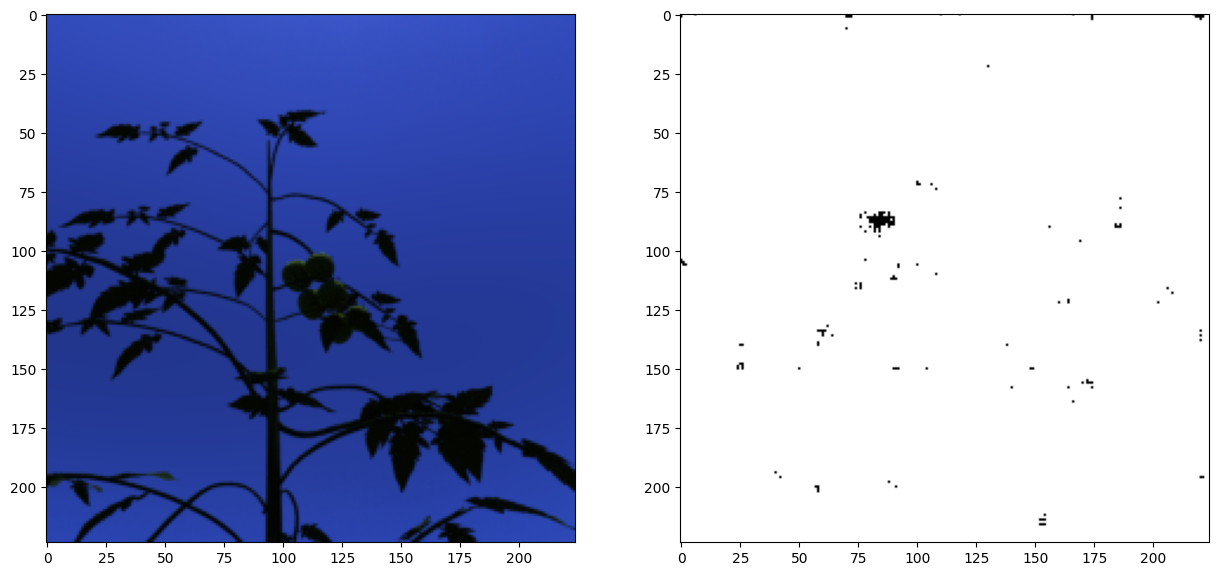

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 197ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


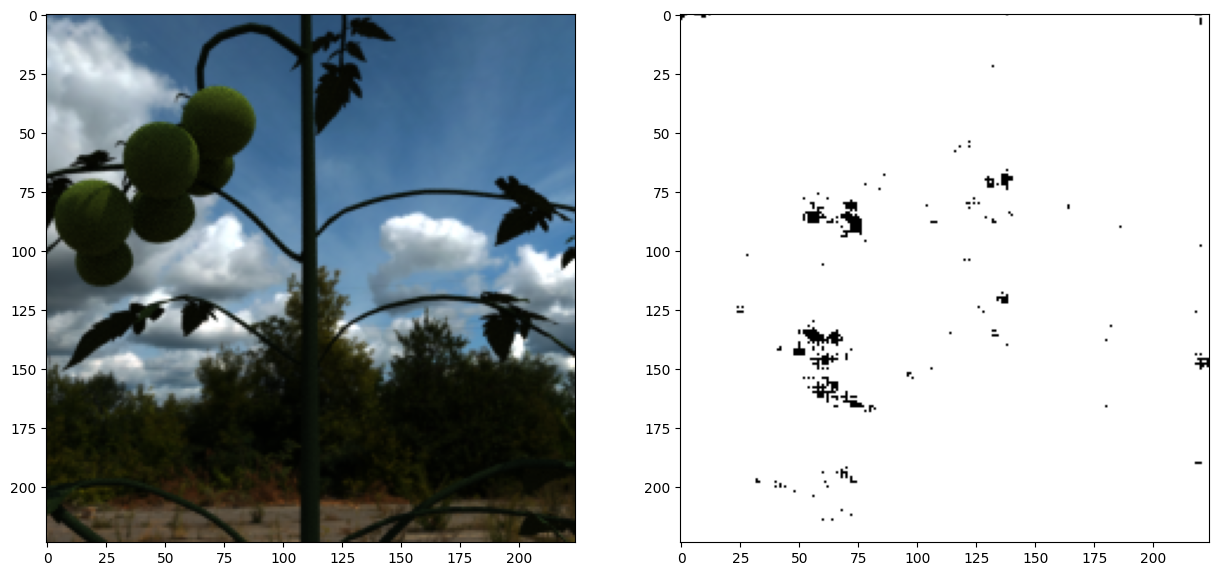

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 202ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


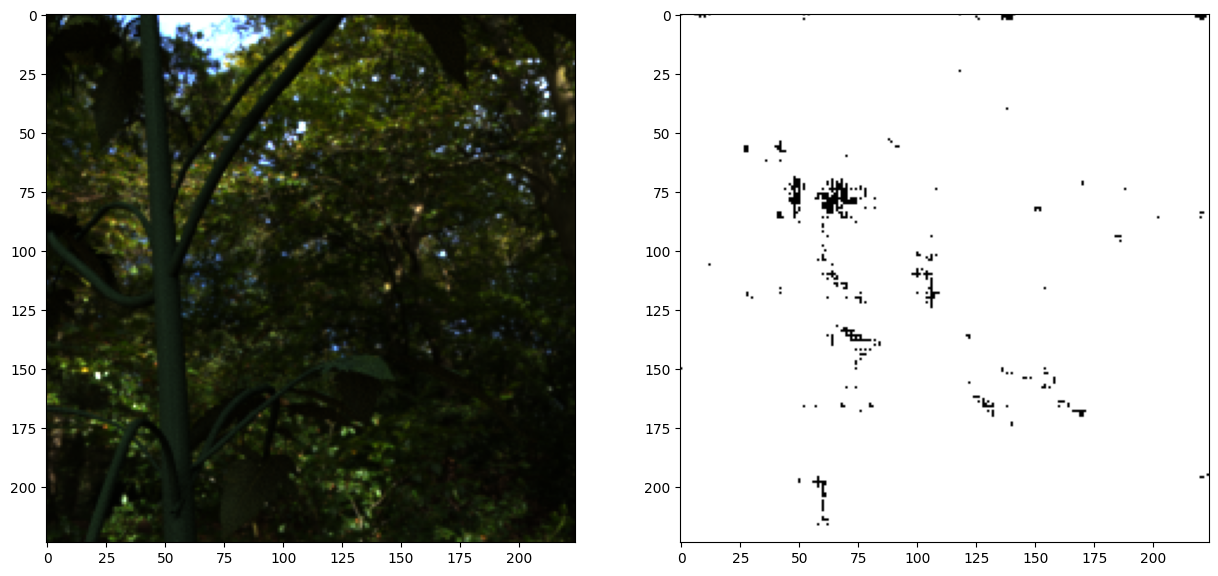

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 226ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


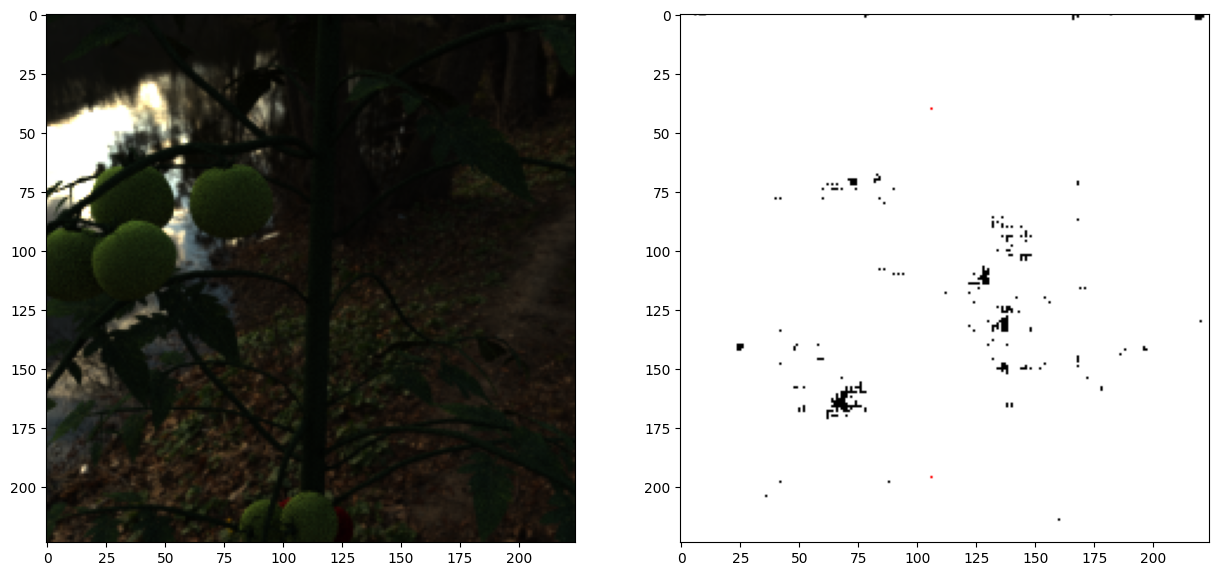

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 221ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


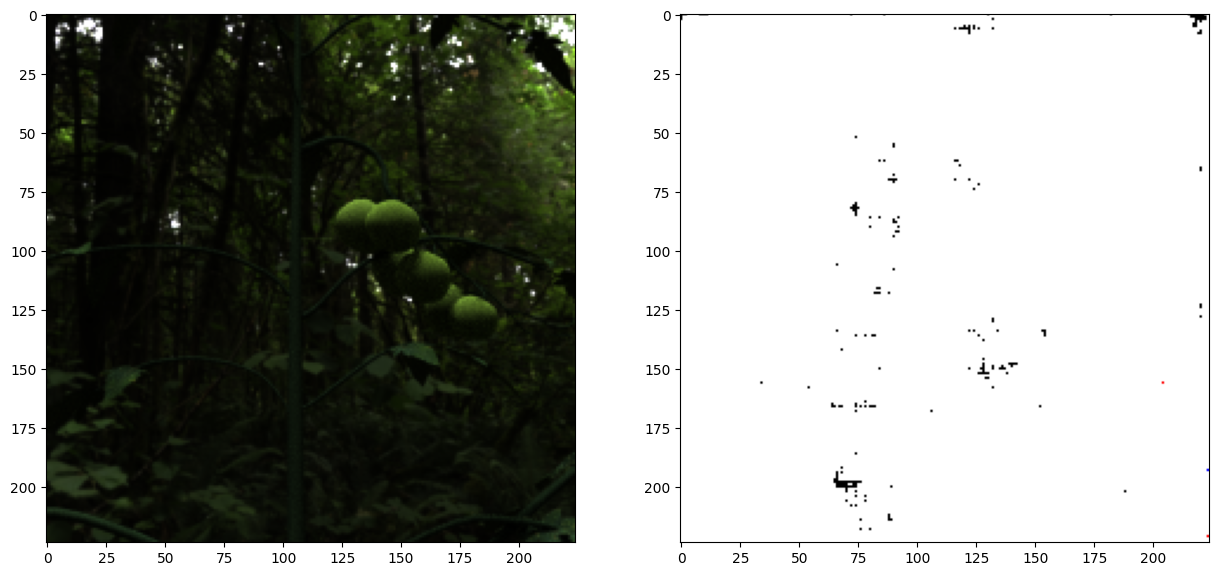

1/1 [==============================] - 0s 322ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


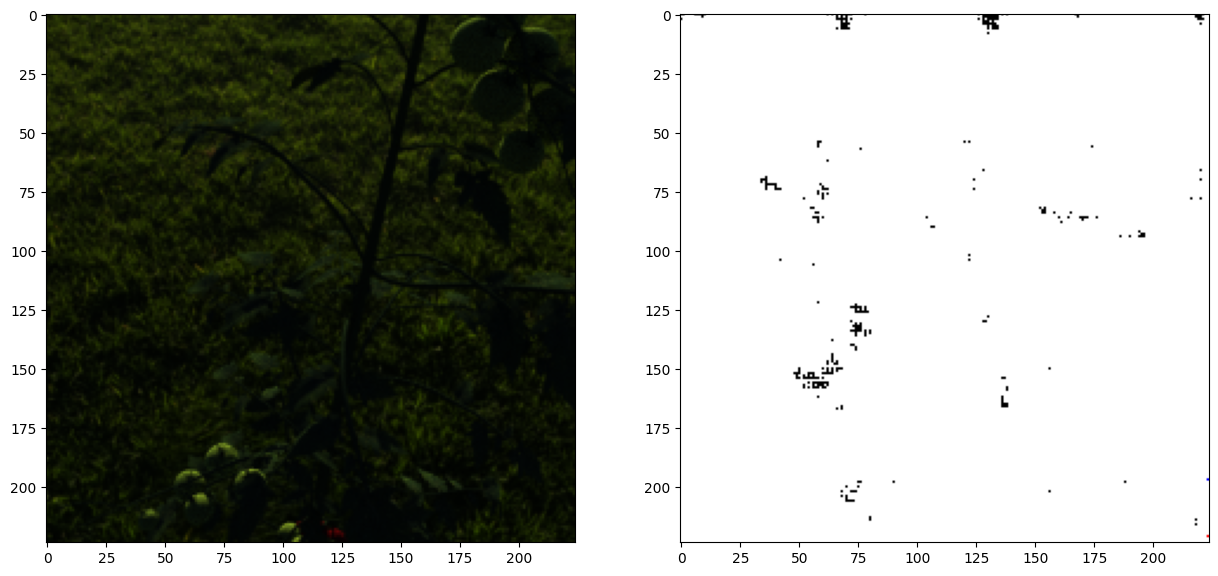

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 214ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


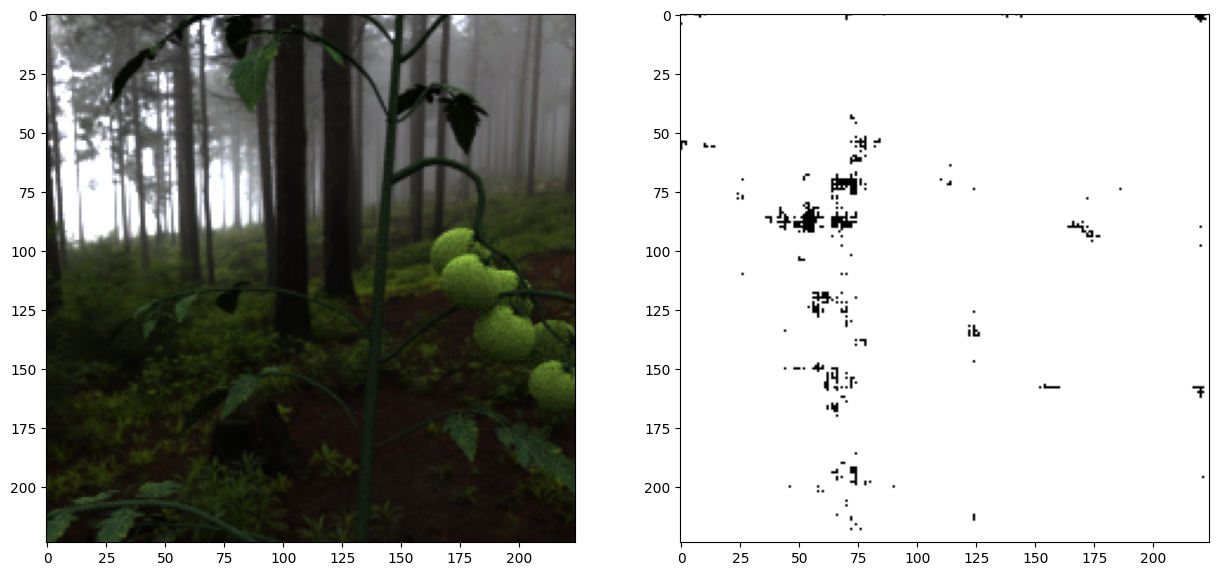

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 221ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


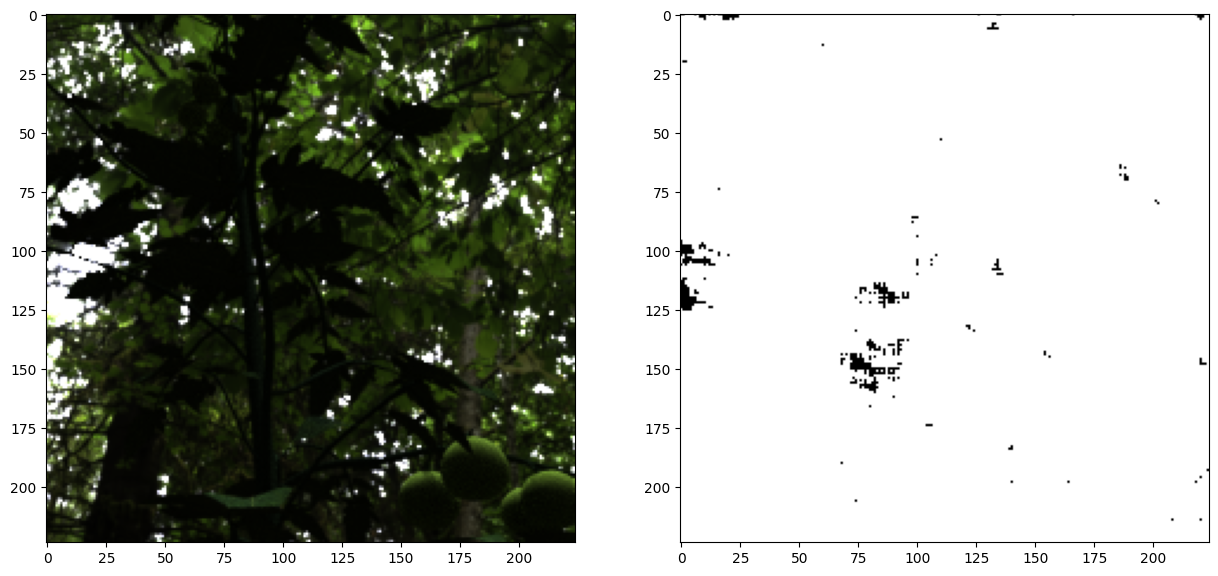

In [14]:
h=0
h_limit = 20

test_list = np.arange(0,h_limit)

for i in test_list:
    if h<h_limit:
        
        img_path = rgb[i]
        original_img = exr_to_jpg(img_path)
        # img_path = testbed_img[i]
        original_img = imageio.imread(img_path)
        original_img = cv2.resize(original_img, (224,224))

        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)    
        plt.imshow(original_img)
        array_img=img_to_array(original_img)/255
       
        array_img2 = np.reshape(array_img, (1,224,224,3))

        y_pred=model.predict(array_img2)
        y_pred=np.reshape(y_pred,(224,224,6))

        c=class_pixels(y_pred)
        o=colorize(c)

        # print('y_pred:', y_pred)
        # print("c:", c)
        # print("o:", o)
        plt.subplot(1,2,2)
        plt.imshow(o)
        plt.show()
        h+=1
    else:
        break

In [55]:
!pip install av`./inp
! pip install imageio[freeimage]
imageio.plugins.freeimage.download()

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 4830080/4830080 bytes (100.0%)
  Done
File saved as /home/jy/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.
